In [ ]:
! pip install transformers==4.5.1  tokenizers==0.10.2
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.7 MB/s 
     |████████████████████████████████| 3.3 MB 49.3 MB/s 
     |████████████████████████████████| 880 kB 60.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=72cc80268c28cc842da95f0659dde36df16a0463e1010d4733b1bc1bc5e29a32
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
# Load pre-trained model (weights)
model = GPT2LMHeadModel.from_pretrained('./drive/MyDrive/GPT_MODEL')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

def score(sentence, model):
    model.eval().cuda()
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)]).cuda()
    loss=model(tensor_input, labels=tensor_input).loss
    return math.exp(loss)

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
%ls

drive/  p7_babel.csv  sample_data/  training_set_rel3.tsv


In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import IsolationForest

babel = pd.read_csv('p7_babel.csv',  names= ['text'])['text'].tolist()

fp=open("training_set_rel3.tsv",'r', encoding="ascii", errors="ignore")
fp.readline()
sentences=[]
for line in fp:
    temp=line.split("\t")
    if(temp[1]=='7'): ## why only 4 ?? - evals in prompt specific fashion
        line=temp[2].strip().replace('"','').replace('  ',' ')
        sentences.append(line)

In [ ]:
import sklearn
X_train, X_val = sklearn.model_selection.train_test_split(sentences, test_size = 0.2)

In [ ]:
import random
tot_train = []
for essay in X_train:
    tot_train.append(score(essay, model))

In [ ]:
tot_babel = []
for essay in babel:
    tot_babel.append(score(' '.join(essay.split(' ')[:200]),model))

In [ ]:
tot_test = []
for essay in X_val:
    tot_test.append(score(essay,model))

In [ ]:
tot_train[:2], tot_babel[:2]

([7.66675072192415, 16.02506703979901], [790.6518733791859, 542.8958183807961])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


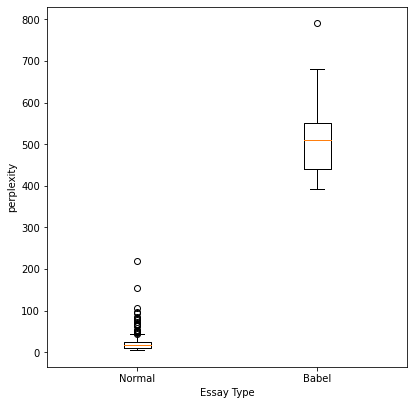

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
 
data = [tot_test, tot_babel]
 
fig = plt.figure(figsize =(5, 5))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
plt.xticks([1, 2], ['Normal', 'Babel'])
plt.xlabel('Essay Type')
plt.ylabel('perplexity')

# show plot
# plt.show()
plt.savefig('box_plot.png', bbox_inches='tight')

In [ ]:
tot_shuffle = []
len_arr = []
for essay in X_val:
    es = essay.split(' ')
    random.shuffle(es)
    essay = ' '.join(es)
    tot_shuffle.append(score(essay,model))
    len_arr.append(len(es))

In [ ]:
from scipy import stats
len_arr = []
for essay in X_train:
  len_arr.append(len(essay.split()))
correlation, p_value = stats.pearsonr(len_arr, tot_train)
correlation

-0.1360143936557756

In [ ]:
clf = IsolationForest(random_state=42, contamination = 0.01)
clf.fit(np.array(tot_train).reshape(-1,1))

IsolationForest(contamination=0.01, random_state=42)

In [ ]:
y_pred_train = clf.predict(np.array(tot_test).reshape(-1,1))
y_pred_test_shuffle = clf.predict(np.array(tot_shuffle).reshape(-1,1))
y_pred_test_babel = clf.predict(np.array(tot_babel).reshape(-1,1))

In [ ]:
#normal
print("Accuracy:", list(y_pred_train).count(1)/y_pred_train.shape[0])

#shuffle
print("Accuracy:", list(y_pred_test_shuffle).count(-1)/y_pred_test_shuffle.shape[0])

#babel
print("Accuracy:", list(y_pred_test_babel).count(-1)/y_pred_test_babel.shape[0])

Accuracy: 0.9840764331210191
Accuracy: 0.9840764331210191
Accuracy: 1.0
